# Udacity Project 1

In [14]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
from datetime import datetime
import plotly.express as px
from datetime import datetime as dt
from pandas_profiling import ProfileReport
import itertools
import plotly.graph_objects as go
from plotly.offline import iplot
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
print('Import done.')

Import done.


In [102]:
df_listings = pd.read_csv(f"C:/develop/VSCode/Udacity/project_1/muc_listings.csv")
df_listings.head()

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 75, dtype: object

In [103]:
df_cal = pd.read_csv(f"C:/develop/VSCode/Udacity/project_1/muc_calendar.csv")
# Change date format
df_cal["date_new"] = pd.to_datetime(df_cal["date"], format="%Y-%m-%d")

df_cal.describe()

listing_id                 int64
date                      object
available                 object
price                     object
adjusted_price            object
minimum_nights           float64
maximum_nights           float64
date_new          datetime64[ns]
dtype: object

#### Prepare amenities column for analysis

In [92]:
# Replace special characters in string and convert to list
df_listings["amenities_list"] = df_listings["amenities"].apply(lambda x: x.replace('"', '')
                                                                          .replace('[', '')
                                                                          .replace(']','')
                                                                          .split(", "))

# Check that list conversion worked
type(df_listings["amenities_list"].values[0])

# Convert list to dummies
# https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
df_amenities = pd.get_dummies(df_listings["amenities_list"].apply(pd.Series).stack()).sum(level=0)
display(HTML(df_amenities.head(3).to_html()))

C:\Users\q514907\AppData\Local\Temp\ipykernel_18852\3023454824.py:12: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



,,Bose sound system with Bluetooth and aux,Monitor Audio sound system,Verschiedene body soap,liquid products of L'Or\u00e9al conditioner,- body soap,-standard- body soap,-standard- conditioner,100\ HDTV with Chromecast,100\ HDTV with Netflix,100\ TV with,100\ TV with Amazon Prime Video,108\ HDTV,10\ HDTV with Amazon Prime Video,120\ HDTV with Amazon Prime Video,120\ HDTV with standard cable,12V Sony Amplifier sound system with aux,15\ TV,1\ HDTV with Amazon Prime Video,2 in 1 Hair shampoo and body lotion body soap,2 in 1 shampoo,2-5 years old,223 l,22\ HDTV with standard cable,22\ TV with standard cable,23\ HDTV with Amazon Prime Video,23\ HDTV with standard cable,23\ TV with standard cable,24\ HDTV with,24\ TV with standard cable,27\ TV with Chromecast,28\ TV with,30\ HDTV,30\ HDTV with Amazon Prime Video,32\ HDTV,32\ HDTV with,32\ HDTV with Amazon Prime Video,32\ HDTV with Netflix,32\ HDTV with premium cable,32\ HDTV with standard cable,32\ TV with standard cable,33\ HDTV with Amazon Prime Video,33\ HDTV with standard cable,35\ HDTV with Netflix,36\ HDTV,36\ HDTV with Netflix,36\ HDTV with standard cable,36\ TV with standard cable,37\ HDTV,37\ HDTV with standard cable,40 dB,40\ HDTV,40\ HDTV with Amazon Prime Video,40\ HDTV with Apple TV,40\ HDTV with Chromecast,40\ HDTV with Netflix,40\ HDTV with premium cable,40\ HDTV with standard cable,40\ TV with standard cable,41\ TV,42\ HDTV,42\ HDTV with,42\ HDTV with Amazon Prime Video,42\ HDTV with Apple TV,42\ HDTV with Netflix,42\ HDTV with premium cable,42\ HDTV with standard cable,42\ TV,42\ TV with Netflix,42\ TV with standard cable,43\ HDTV,43\ HDTV with Amazon Prime Video,43\ HDTV with Chromecast,43\ HDTV with Netflix,43\ HDTV with standard cable,44\ HDTV with Amazon Prime Video,44\ HDTV with Netflix,45\ HDTV,45\ HDTV with Amazon Prime Video,45\ HDTV with Netflix,45\ HDTV with standard cable,45\ TV,46\ HDTV,46\ HDTV with Amazon Prime Video,46\ HDTV with Chromecast,46\ HDTV with standard cable,47\ HDTV with Apple TV,47\ HDTV with Netflix,47\ HDTV with premium cable,47\ HDTV with standard cable,47\ TV with,48\ HDTV with Amazon Prime Video,48\ HDTV with Netflix,48\ HDTV with premium cable,48\ HDTV with standard cable,49\ HDTV with Amazon Prime Video,49\ HDTV with Netflix,49\ HDTV with standard cable,5-10 years old,50\ HDTV,50\ HDTV with,50\ HDTV with Amazon Prime Video,50\ HDTV with Apple TV,50\ HDTV with Chromecast,50\ HDTV with Netflix,50\ HDTV with premium cable,50\ HDTV with standard cable,50\ TV,50\ TV with Amazon Prime Video,50\ TV with Apple TV,51\ HDTV with Netflix,52\ HDTV,52\ HDTV with Amazon Prime Video,52\ HDTV with Netflix,52\ HDTV with standard cable,54\ HDTV with Netflix,54\ HDTV with standard cable,55\ HDTV,55\ HDTV with,55\ HDTV with Amazon Prime Video,55\ HDTV with Apple TV,55\ HDTV with Chromecast,55\ HDTV with Netflix,55\ HDTV with premium cable,55\ HDTV with standard cable,55\ TV,55\ TV with Chromecast,55\ TV with Netflix,56\ HDTV with Amazon Prime Video,57\ HDTV,58\ HDTV with Amazon Prime Video,58\ HDTV with standard cable,59\ HDTV with Amazon Prime Video,59\ TV,60\ HDTV,60\ HDTV with Amazon Prime Video,60\ HDTV with Netflix,60\ HDTV with premium cable,60\ TV,60\ TV with,60\ TV with Amazon Prime Video,60\ TV with standard cable,62\ HDTV with Netflix,64\ HDTV with Amazon Prime Video,65\ HDTV,65\ HDTV with Amazon Prime Video,65\ HDTV with Apple TV,65\ HDTV with Chromecast,65\ HDTV with Netflix,65\ HDTV with standard cable,65\ TV with Netflix,69\ HDTV,70\ HDTV with Chromecast,70\ HDTV with Netflix,70\ TV with standard cable,72\ HDTV,72\ HDTV with Netflix,75\ HDTV,75\ HDTV with Amazon Prime Video,75\ HDTV with Apple TV,75\ HDTV with Netflix,75\ HDTV with standard cable,75\ TV,75\ TV with Amazon Prime Video,76\ HDTV with Amazon Prime Video,77\ HDTV with standard cable,78\ TV with standard cable,80\ TV with Amazon Prime Video,85\ HDTV with Netflix,86\ HDTV with premium cable,A+,AC - split type ductless system,ADA body soap,ADA shampoo,AEG refrigerator,AEG stainl

##### Identify how many unique amenity dummy columns to keep

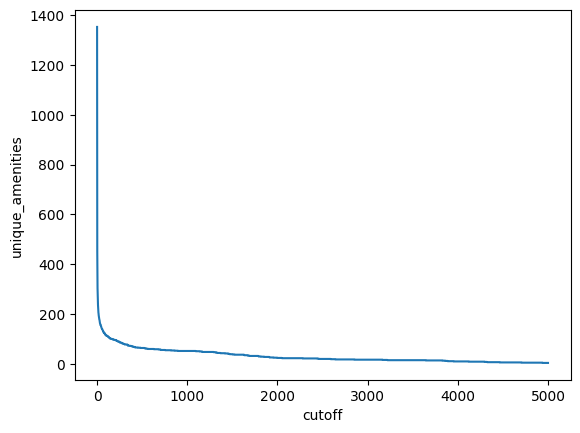

In [89]:
# Keep only values above threshold: 
# https://stackoverflow.com/questions/29281815/pandas-select-dataframe-columns-using-boolean

cutoff_data = []
# Visually inspect which is the best cutoff
for cutoff in range(5000):
    amenities_keep = df_amenities.sum() > cutoff
    cutoff_data.append(len(amenities_keep.index[amenities_keep]))

df_cutoff = pd.DataFrame(cutoff_data)
df_cutoff = df_cutoff.reset_index()
df_cutoff = df_cutoff.rename(columns={"index":"cutoff", 0:"unique_amenities"})

# Plot unique amenities columns per cutoff value
sns.lineplot(data=df_cutoff, x="cutoff", y="unique_amenities")
plt.show()

# > Preliminary cutoff value: 20

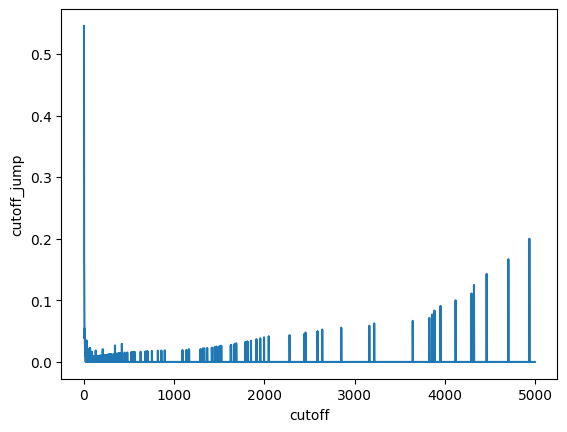

In [90]:
df_cutoff["prev_cutoff"] = df_cutoff["unique_amenities"].shift(-1)
df_cutoff["cutoff_jump"] = 1 - df_cutoff["prev_cutoff"] / df_cutoff["unique_amenities"]
df_cutoff


sns.lineplot(data=df_cutoff, x="cutoff", y="cutoff_jump")
plt.show()

## Clean Price Data

Share of nulls for price: 0


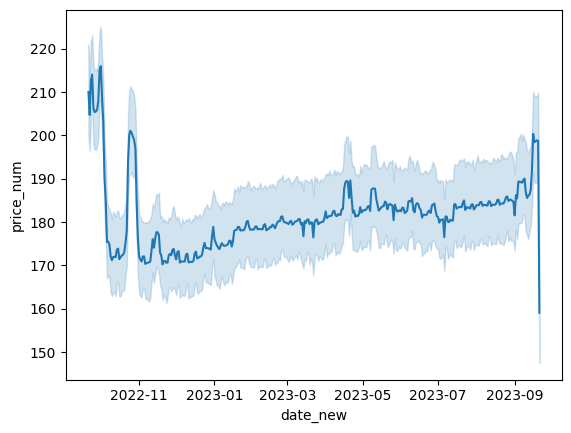

In [148]:
# Check nulls for price data
print(f"Share of nulls for price: {df_cal['price'].isna().sum()}")

# Check that currency is always $
df_cal["currency"] = df_cal["price"].str[:1]
df_cal["currency"].unique()

# Check for decimals > always .00
df_cal["price_check"] = df_cal["price"].str[-3:]
df_cal["price_check"].unique()

# Cut decimals and replace $
df_cal["price_num"] = df_cal["price"].str[1:-3]
# df_cal["price_num"] = df_cal["price"].replace(".00", "TEST", inplace=False)
# df_cal["price_num"].astype(float)

df_cal["price_num"] = df_cal["price"].str[1:-3].apply(lambda x: x.replace(",", "")).astype(float)
df_cal["price_num"]

# Convert to float
# df_cal["price_num"] = df_cal["price"].str[1:].astype(float)
# df_cal.head(20)

# Seasonal price variation
sns.lineplot(data=df_cal, x="date_new", y="price_num")
plt.show()

In [155]:
df_cal_grouped = df_cal.groupby("listing_id").agg({"price_num":"mean"}, axis=0)
# df_cal_grouped.rename(columns={"price_num":"price_avg"}, inplace=True)

df_cal_grouped = df_cal_grouped.reset_index()
# df_cal_grouped["listing_id"] = df_cal_grouped["listing_id"].astype("int")

df_cal_grouped.dtypes

listing_id      int64
price_num     float64
dtype: object

In [156]:
# New groupby logic to potentially add different aggregations per column if necessary
# 3https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns

df_cal_grouped = df_cal.groupby("listing_id").agg({"price_num":"mean"}, axis=0)
df_cal_grouped.rename(columns={"price_num":"price_avg"}, inplace=True)

df_cal_grouped = df_cal_grouped.reset_index()
# df_cal_grouped["listing_id"] = df_cal_grouped["listing_id"].astype("int")

df_joined = pd.merge(df_listings, df_cal_grouped, left_on="id", right_on="listing_id", how="left")
print(f"Share of missing price values in df_cal_grouped: {df_cal_grouped['price_avg'].isna().sum() / df_cal_grouped.shape[0]}")
print(f"Share of missing price values in df_joined: {df_joined['price_avg'].isna().sum() / df_joined.shape[0]}")
df_joined.head()


Share of missing price values in df_cal_grouped: 0.0
Share of missing price values in df_joined: 0.0


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,listing_id,price_avg
0,21641918,https://www.airbnb.com/rooms/21641918,20220921172344,2022-09-21,city scrape,Gemütliches helles Gästezimmer nahe München,Sehr schönes helles Zimmer im Dachgeschoß mit ...,NaN,https://a0.muscache.com/pictures/aafaf797-4be0...,20805795,...,4.93,NaN,f,1,0,1,0,1.98,21641918,56.920548
1,14711185,https://www.airbnb.com/rooms/14711185,20220921172344,2022-09-21,city scrape,Mi casa es su casa,In unserer Wohnung mit einem gemütlichen Schla...,Es gibt viel Grün im Ort - viele Spielplätze u...,https://a0.muscache.com/pictures/8941737c-be2e...,56395839,...,4.59,NaN,f,1,0,1,0,0.26,14711185,36.613699
2,20162448,https://www.airbnb.com/rooms/20162448,20220921172344,2022-09-21,city scrape,Shabby chic 30 minutes to Oktoberfest .,Shabby Chic 30 minutes from Oktoberfest. Share...,You`ll reach the pretty riverside of Isar with...,https://a0.muscache.com/pictures/25e4368a-7e06...,41482289,...,4.29,NaN,f,1,0,1,0,0.11,20162448,120.000000
3,24837769,https://www.airbnb.com/rooms/24837769,20220921172344,2022-09-21,city scrape,Hohenbrunn(MUC)-Zuhause mit Aussicht und City ...,"Wunderschöne, große 2-Zimmer-Wohnung im Grünen...",Die Nachbarschaft ist sehr liebevoll und freun...,https://a0.muscache.com/pictures/fbb115cc-510e...,172211954,...,4.60,NaN,f,1,1,0,0,0.39,24837769,79.739726
4,20900945,https://www.airbnb.com/rooms/20900945,20220921172344,2022-09-21,city scrape,Guesthouse at fasanenpark,(20 minutes to the Oktoberfest. The train stat...,NaN,https://a0.muscache.com/pictures/ac4f0d1b-b394...,150163486,...,4.72,NaN,f,1,0,1,0,0.49,20900945,62.958904


#### Investigate ID Mapping Issue > problem resolved (due to changing int id to int again)

In [ ]:
# Number of unique IDs is the same
print(f"Unique IDs in df_listings: {len(df_listings['id'].unique())}")
print(f"Unique IDs in df_cal: {len(df_cal['listing_id'].unique())}")

df_id_listings = pd.DataFrame(df_listings["id"].unique())
df_id_listings["source"] = "listings"
df_id_listings.rename(columns={0:"listing_id"}, inplace=True)


df_id_cal = pd.DataFrame(df_cal["listing_id"].unique())
df_id_cal["source"] = "calendar"
df_id_cal.rename(columns={0:"listing_id"}, inplace=True)

df_id_joined = pd.merge(df_id_listings, df_id_cal, on="listing_id", how="outer")


# Check null values per column (IDs that were only contained in one of the two source tables)
df_id_joined.isnull().sum()

Unique IDs in df_listings: 6627
Unique IDs in df_cal: 6627


#### Prepare neighborhoods data for model

In [175]:
# Check if column neighborhood_cleansed can be used (e.g. null values)
df_listings["neighbourhood_cleansed"].value_counts()

# Get number of listings per neighborhood
df_neighborhoods = pd.DataFrame(df_listings["neighbourhood_cleansed"].value_counts())
df_neighborhoods["neighbourhood_cleansed"].sum()

# No null values
df_listings["neighbourhood_cleansed"].isnull().sum()
df_neighborhoods

# Add neighborhood dummies to main df
df_joined = pd.get_dummies(df_joined, columns=["neighbourhood_cleansed"])
df_joined

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,neighbourhood_cleansed_Pasing-Obermenzing,neighbourhood_cleansed_Ramersdorf-Perlach,neighbourhood_cleansed_Schwabing-Freimann,neighbourhood_cleansed_Schwabing-West,neighbourhood_cleansed_Schwanthalerhöhe,neighbourhood_cleansed_Sendling,neighbourhood_cleansed_Sendling-Westpark,neighbourhood_cleansed_Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln,neighbourhood_cleansed_Tudering-Riem,neighbourhood_cleansed_Untergiesing-Harlaching
0,21641918,https://www.airbnb.com/rooms/21641918,20220921172344,2022-09-21,city scrape,Gemütliches helles Gästezimmer nahe München,Sehr schönes helles Zimmer im Dachgeschoß mit ...,NaN,https://a0.muscache.com/pictures/aafaf797-4be0...,20805795,...,0,0,0,0,0,0,0,1,0,0
1,14711185,https://www.airbnb.com/rooms/14711185,20220921172344,2022-09-21,city scrape,Mi casa es su casa,In unserer Wohnung mit einem gemütlichen Schla...,Es gibt viel Grün im Ort - viele Spielplätze u...,https://a0.muscache.com/pictures/8941737c-be2e...,56395839,...,0,1,0,0,0,0,0,0,0,0
2,20162448,https://www.airbnb.com/rooms/20162448,20220921172344,2022-09-21,city scrape,Shabby chic 30 minutes to Oktoberfest .,Shabby Chic 30 minutes from Oktoberfest. Share...,You`ll reach the pretty riverside of Isar with...,https://a0.muscache.com/pictures/25e4368a-7e06...,41482289,...,0,0,0,0,0,0,0,1,0,0
3,24837769,https://www.airbnb.com/rooms/24837769,20220921172344,2022-09-21,city scrape,Hohenbrunn(MUC)-Zuhause mit Aussicht und City ...,"Wunderschöne, große 2-Zimmer-Wohnung im Grünen...",Die Nachbarschaft ist sehr liebevoll und freun...,https://a0.muscache.com/pictures/fbb115cc-510e...,172211954,...,0,1,0,0,0,0,0,0,0,0
4,20900945,https://www.airbnb.com/rooms/20900945,20220921172344,2022-09-21,city scrape,Guesthouse at fasanenpark,(20 minutes to the Oktoberfest. The train stat...,NaN,https://a0.muscache.com/pictures/ac4f0d1b-b394...,150163486,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6622,51166000,https://www.airbnb.com/rooms/51166000,20220921172344,2022-09-21,city scrape,Mordernes Zimmer Stadtnah,Privatzimmer in einer modernen Doppelhaushälft...,NaN,https://a0.muscache.com/pictures/ce654ca8-99cd...,69031130,...,0,0,0,0,0,0,0,0,1,0
6623,27539320,https://www.airbnb.com/rooms/27539320,20220921172344,2022-09-21,city scrape,Zimmer mit Balkon in Trudering- Haar,ich biete euch ein gemütliches und ruhiges Zim...,Ruhige und sehr nette Nachbarschaft. Schöner u...,https://a0.muscache.com/pictures/c6c05799-10b7...,200752521,...,0,0,0,0,0,0,0,0,1,0
6624,717958913690010370,https://www.airbnb.com/rooms/717958913690010370,20220921172344,2022-09-21,city scrape,Großes ruhiges Studio Nähe Messe München,Unmittelbar im Osten der quirligen Stadt Münch...,Das Studio liegt an einer kleinen Strasse mit ...,https://a0.muscache.com/pictures/af2ebd9c-963e...,479882004,...,0,0,0,0,0,0,0,0,1,0
6625,211250,https://www.airbnb.com/rooms/211250,20220921172344,2022-09-21,city scrape,Apartment near Munich Trade Fair,<b>The space</b><br />Our apartment is situate...,NaN,https://a0.muscache.com/pictures/10937691/cc28...,1041289,...,0,0,0,0,0,0,0,0,1,0


## Model Setup

In [223]:
# Columns to keep from df_listings
col_keep = []
col_excl = ["id", "scrape_id", "host_id", "neighbourhood_group_cleansed","longitude", "latitude", "minimum_nights", "maximum_nights", "minimum_minimum_nights", "maximum_minimum_nights",
            "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "listing_id"] 

# Exclude object-type columns & selected columns
df_model = df_joined.select_dtypes(exclude="object").drop(col_excl, axis=1)
df_model

# Check nulls per columns
# https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset
percent_missing = df_model.isnull().sum() * 100 / len(df_model)
missing_value_df = pd.DataFrame({'column_name': df_model.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

df_model.dropna(axis=1, inplace=True)

0       2
1       1
2       2
3       2
4       2
       ..
6622    2
6623    2
6624    4
6625    2
6626    2
Name: accommodates, Length: 6627, dtype: int64

In [224]:
df_joined["bathrooms_text"].unique()

array(['1 private bath', '1 shared bath', '1.5 shared baths', '1 bath',
       '2.5 shared baths', '2.5 baths', '1.5 baths', '3 shared baths',
       'Shared half-bath', nan, '3 baths', '2 baths', '2 shared baths',
       '0 shared baths', 'Half-bath', '0 baths', '3.5 shared baths',
       '3.5 baths', '4 baths', '24 baths', '5 baths', '4 shared baths',
       '23 baths', '26 shared baths', '27 shared baths', '12 baths',
       'Private half-bath', '5.5 baths'], dtype=object)

In [216]:
display(HTML(df_model.head(3).to_html()))

,host_listings_count,host_total_listings_count,accommodates,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,listing_id,price_avg,neighbourhood_cleansed_Allach-Untermenzing,neighbourhood_cleansed_Altstadt-Lehel,neighbourhood_cleansed_Au-Haidhausen,neighbourhood_cleansed_Aubing-Lochhausen-Langwied,neighbourhood_cleansed_Berg am Laim,neighbourhood_cleansed_Bogenhausen,neighbourhood_cleansed_Feldmoching-Hasenbergl,neighbourhood_cleansed_Hadern,neighbourhood_cleansed_Laim,neighbourhood_cleansed_Ludwigsvorstadt-Isarvorstadt,neighbourhood_cleansed_Maxvorstadt,neighbourhood_cleansed_Milbertshofen-Am Hart,neighbourhood_cleansed_Moosach,neighbourhood_cleansed_Neuhausen-Nymphenburg,neighbourhood_cleansed_Obergiesing,neighbourhood_cleansed_Pasing-Obermenzing,neighbourhood_cleansed_Ramersdorf-Perlach,neighbourhood_cleansed_Schwabing-Freimann,neighbourhood_cleansed_Schwabing-West,neighbourhood_cleansed_Schwanthalerhöhe,neighbourhood_cleansed_Sendling,neighbourhood_cleansed_Sendling-Westpark,neighbourhood_cleansed_Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln,neighbourhood_cleansed_Tudering-Riem,neighbourhood_cleansed_Untergiesing-Harlaching
0,1,1,2,12,28,55,124,116,28,4,1,0,1,0,21641918,56.920548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,1,1,3,3,3,3,19,1,1,1,0,1,0,14711185,36.613699,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,2,2,25,47,77,352,7,1,0,1,0,1,0,20162448,120.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [204]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [222]:
# Prepare train and test data sets
X = df_model.drop(["price_avg"], axis=1)
y = df_model[["price_avg"]]

# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)
lm_model = LinearRegression(normalize=True)

# # If our model works, it should just fit our model to the data. Otherwise, it will let us know.
lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)
r2_test =  r2_score(y_test, y_test_preds) # Rsquared here for comparing test and preds from lm_2_model

# Print r2 to see result
r2_test

c:\Users\q514907\Anaconda3\envs\udacity\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)





0.18685462531115293

In [ ]:
# Pandas profiling (takes long!)
# listings_profile = ProfileReport(df_listings, title="Pandas Profiling Report")
# listings_profile.to_file("your_report.html")